In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import pandas as pd
plt.rcParams["figure.dpi"] = 150

# Population

In [2]:
anime = pd.read_csv("anime.csv")
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24012 entries, 0 to 24011
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           24012 non-null  int64  
 1   title                        24012 non-null  object 
 2   media_type                   24012 non-null  object 
 3   scoring                      14153 non-null  float64
 4   num_scoring_users            24012 non-null  int64  
 5   status                       24012 non-null  object 
 6   num_episodes                 24012 non-null  int64  
 7   start_date                   21160 non-null  object 
 8   end_date                     19719 non-null  object 
 9   source                       20238 non-null  object 
 10  num_list_users               24012 non-null  int64  
 11  popularity                   20538 non-null  float64
 12  num_favorites                24012 non-null  int64  
 13  rank            

In [70]:
anime.head()

,id,title,media_type,scoring,num_scoring_users,status,num_episodes,start_date,end_date,source,...,studios,synopsis,nsfw,created_at,updated_at,main_picture_medium,main_picture_large,alternative_titles_en,alternative_titles_ja,alternative_titles_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.14,1846307,finished_airing,64,2009-04-05 00:00:00,2010-07-04 00:00:00,manga,...,['Bones'],After a horrific alchemy experiment goes wrong...,white,2008-08-21 03:35:22,2022-04-18 05:06:13,https://api-cdn.myanimelist.net/images/anime/1...,https://api-cdn.myanimelist.net/images/anime/1...,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.05,1488156,finished_airing,148,2011-10-02 00:00:00,2014-09-24 00:00:00,manga,...,"['Madhouse', 'Studio Live']",Hunters devote themselves to accomplishing haz...,white,2011-07-27 08:41:39,2022-04-18 05:11:21,https://api-cdn.myanimelist.net/images/anime/1...,https://api-cdn.myanimelist.net/images/anime/1...,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,9253,Steins;Gate,tv,9.08,1240087,finished_airing,24,2011-04-06 00:00:00,2011-09-14 00:00:00,visual_novel,...,['White Fox'],Eccentric scientist Rintarou Okabe has a never...,white,2010-07-26 09:23:40,2022-05-01 21:24:42,https://api-cdn.myanimelist.net/images/anime/5...,https://api-cdn.myanimelist.net/images/anime/5...,Steins;Gate,STEINS;GATE,[]
3,21,One Piece,tv,8.65,1076776,currently_airing,0,1999-10-20 00:00:00,NaN,manga,...,['Toei Animation'],"Gol D. Roger was known as the ""Pirate King,"" t...",white,2005-11-11 01:20:50,2022-04-18 05:12:08,https://api-cdn.myanimelist.net/images/anime/6...,https://api-cdn.myanimelist.net/images/anime/6...,One Piece,ONE PIECE,['OP']
4,1535,Death Note,tv,8.62,2426765,finished_airing,37,2006-10-04 00:00:00,2007-06-27 00:00:00,manga,...,['Madhouse'],"Brutal murders, petty thefts, and senseless vi...",white,2006-10-04 03:39:19,2022-04-18 04:59:29,https://api-cdn.myanimelist.net/images/anime/9...,https://api-cdn.myanimelist.net/images/anime/9...,Death Note,デスノート,['DN']


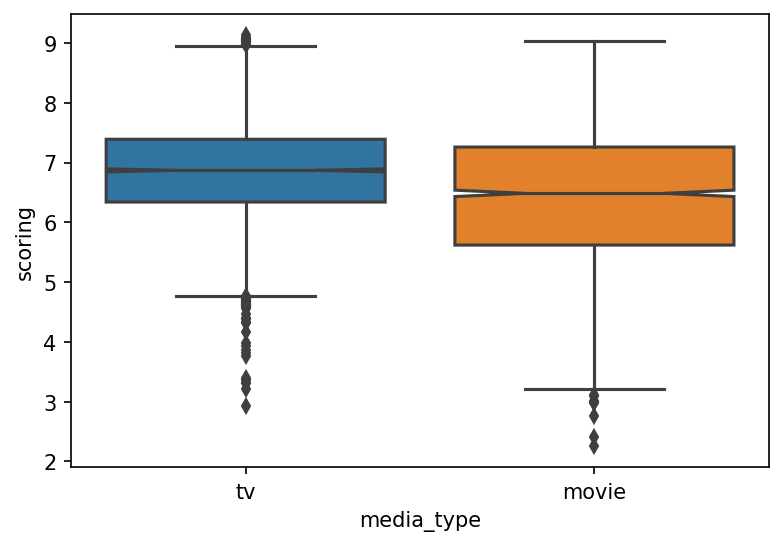

In [3]:
anime_tv_movie = anime.loc[anime.media_type.isin(["tv", "movie"]), :].dropna(subset=["scoring"])
ax = sns.boxplot(x="media_type", y="scoring", data=anime_tv_movie, notch=True)

In [4]:
counts = anime_tv_movie.media_type.value_counts()
counts

tv       4175
movie    2282
Name: media_type, dtype: int64

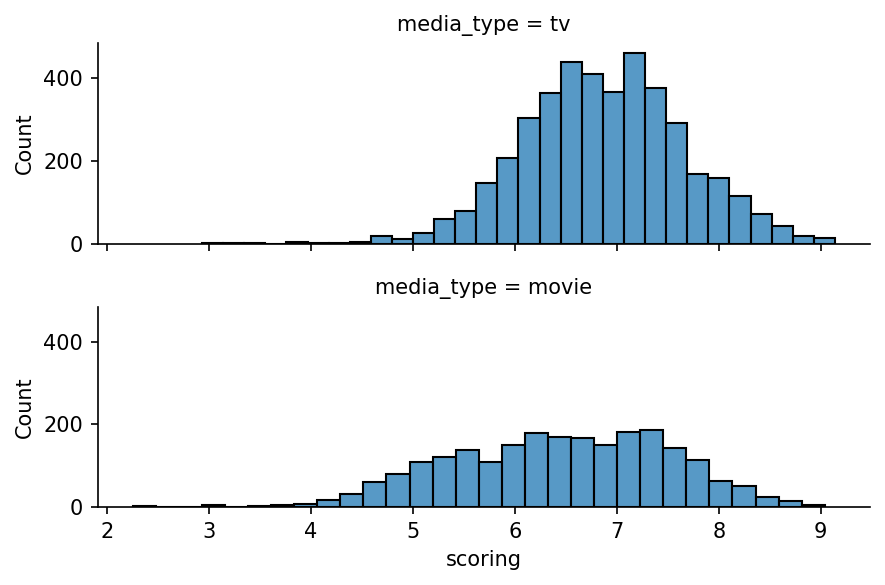

In [5]:
g = sns.FacetGrid(anime_tv_movie, row="media_type", height=2, aspect=3)
g.map(sns.histplot, "scoring", bins=30);

In [6]:
tv_movie_diff_mean_scoring = np.mean(anime_tv_movie.loc[anime_tv_movie.media_type == "tv", "scoring"]) \
    - np.mean(anime_tv_movie.loc[anime_tv_movie.media_type == "movie", "scoring"])

Population parameter

In [7]:
tv_movie_diff_mean_scoring

0.43272950295727686

In [8]:
tv_movie_stdevs = anime_tv_movie.groupby("media_type")["scoring"].apply(np.std)
tv_movie_stdevs

media_type
movie    1.063442
tv       0.795004
Name: scoring, dtype: float64

# Sampling distribution
## Samples of size 200

In [9]:
def create_diff_means_sampling_dist(population, score_column, group_column, group_labels, group_sizes, num_resamples):
    first_population_group = population.loc[
        population[group_column] == group_labels[0], score_column
    ]
    second_population_group = population.loc[
        population[group_column] == group_labels[1], score_column
    ]
    
    samples_sizes_string = f"({group_sizes[0]},{group_sizes[1]})"

    sampling_dist_diffs = []
    for i in range(num_resamples):
        first_group_sample = first_population_group.sample(group_sizes[0], replace=False)
        second_group_sample = second_population_group.sample(group_sizes[1], replace=False)
        
        first_group_sample_mean = first_group_sample.mean()
        second_group_sample_mean = second_group_sample.mean()
        
        this_diff = first_group_sample_mean - second_group_sample_mean
        
        sampling_dist_diffs.append([i + 1, samples_sizes_string, \
            first_group_sample_mean, second_group_sample_mean, this_diff])
    
    return pd.DataFrame(
        data=sampling_dist_diffs, 
        columns=["resample", "sample_sizes", f"{group_labels[0]}_mean_{score_column}", \
            f"{group_labels[1]}_mean_{score_column}", "diff_means"]
    )

In [10]:
sampling_dist_diffs_200 = create_diff_means_sampling_dist(
    population=anime_tv_movie, 
    score_column="scoring", 
    group_column="media_type", 
    group_labels=["tv", "movie"], 
    group_sizes=[200, 200], 
    num_resamples=50000
)

In [11]:
sampling_dist_diffs_200

,resample,sample_sizes,tv_mean_scoring,movie_mean_scoring,diff_means
0,1,"(200,200)",6.80050,6.48760,0.31290
1,2,"(200,200)",6.86625,6.39085,0.47540
2,3,"(200,200)",6.84635,6.35215,0.49420
3,4,"(200,200)",6.81120,6.43010,0.38110
4,5,"(200,200)",6.87645,6.42645,0.45000
...,...,...,...,...,...
49995,49996,"(200,200)",6.78265,6.40200,0.38065
49996,49997,"(200,200)",6.89465,6.44825,0.44640
49997,49998,"(200,200)",6.88750,6.39030,0.49720
49998,49999,"(200,200)",6.83170,6.32240,0.50930


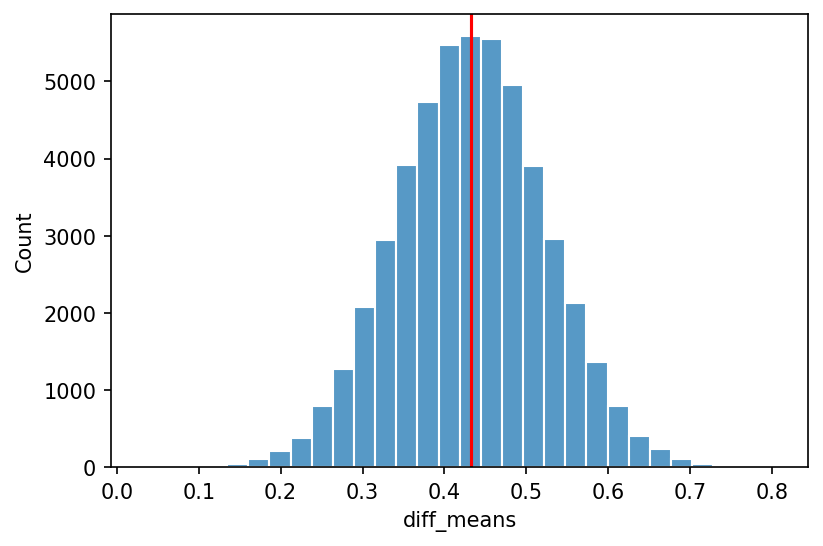

In [12]:
ax = sns.histplot(sampling_dist_diffs_200.diff_means, bins=30, edgecolor="white");
plt.axvline(tv_movie_diff_mean_scoring, 0, 1, color="red");

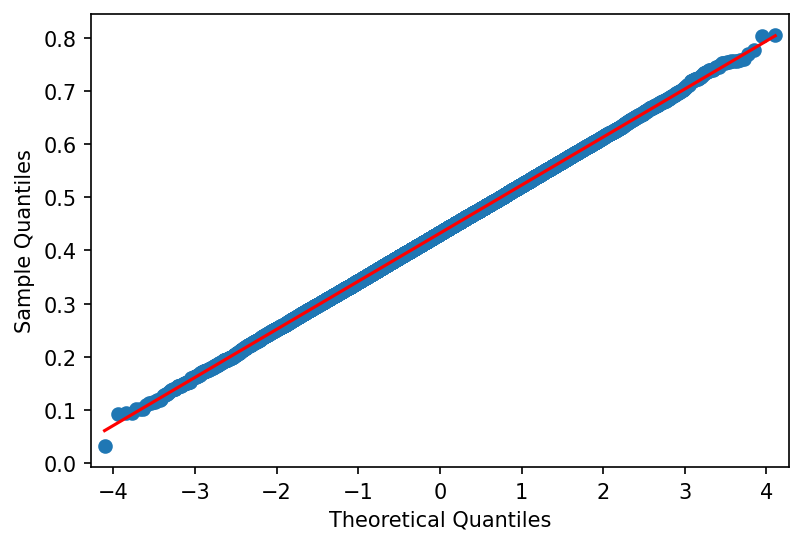

In [13]:
sm.qqplot(sampling_dist_diffs_200.diff_means, line="s");

In [14]:
np.quantile(sampling_dist_diffs_200.diff_means, [0.025, 0.975]) 

array([0.2559475, 0.60935  ])

## Samples of size 1000

In [15]:
sampling_dist_diffs_1000 = create_diff_means_sampling_dist(
    population=anime_tv_movie, 
    score_column="scoring", 
    group_column="media_type", 
    group_labels=["tv", "movie"], 
    group_sizes=[1000, 1000], 
    num_resamples=50000
)

In [16]:
sampling_dist_diffs = pd.concat([sampling_dist_diffs_200, sampling_dist_diffs_1000], axis=0, ignore_index=True)

In [17]:
sampling_dist_diffs

,resample,sample_sizes,tv_mean_scoring,movie_mean_scoring,diff_means
0,1,"(200,200)",6.80050,6.48760,0.31290
1,2,"(200,200)",6.86625,6.39085,0.47540
2,3,"(200,200)",6.84635,6.35215,0.49420
3,4,"(200,200)",6.81120,6.43010,0.38110
4,5,"(200,200)",6.87645,6.42645,0.45000
...,...,...,...,...,...
99995,49996,"(1000,1000)",6.88975,6.42679,0.46296
99996,49997,"(1000,1000)",6.87043,6.44462,0.42581
99997,49998,"(1000,1000)",6.90624,6.45568,0.45056
99998,49999,"(1000,1000)",6.88193,6.42878,0.45315


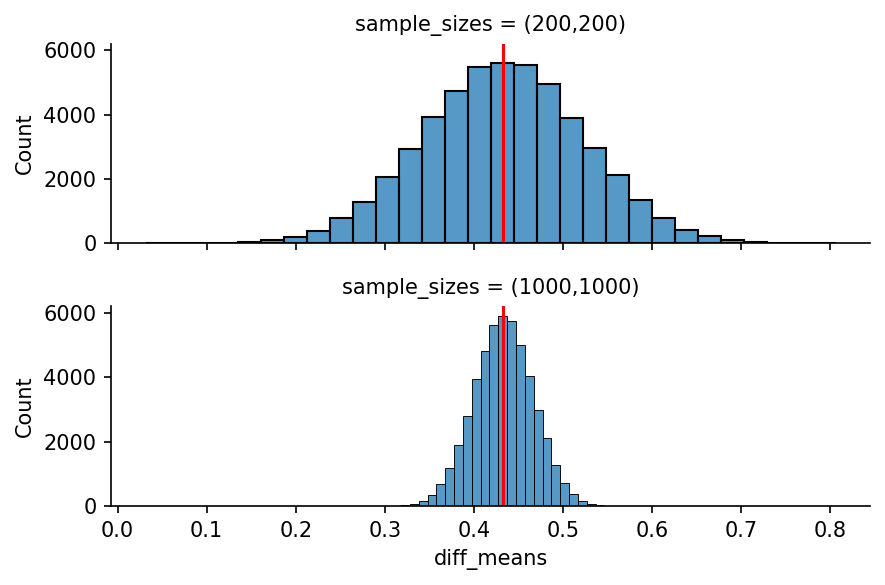

In [18]:
g = sns.FacetGrid(sampling_dist_diffs, row="sample_sizes", height=2, aspect=3)
g.map(sns.histplot, "diff_means", bins=30);
g.map(plt.axvline, x=tv_movie_diff_mean_scoring, ymin=0, ymax=1, color="red");

In [19]:
sampling_dist_diffs \
    .groupby("sample_sizes") \
    .diff_means \
    .agg(
        count=np.size,
        lower_interval=lambda x: np.quantile(x, 0.025),
        upper_interval=lambda x: np.quantile(x, 0.975),
        standard_error=np.std
    )

,count,lower_interval,upper_interval,standard_error
sample_sizes,,,,
"(1000,1000)",50000,0.367249,0.49826,0.033432
"(200,200)",50000,0.255947,0.60935,0.090375


# Central limit theorem

What we've done above is a thought exercise only. In **inferential statistics** we typically:

* don't have access to the whole population. If we did, we calculate the property of interest once, and that's the end of the story (and this would fall in the remit of **descriptive statistics**)
* don't repeatedly sample from the population. Typically, we take one sample, and we make it as large as cost/practicality allow, or as we've determined will provide the *statistical power* necessary to reliably detect the effect we're interested in

$\sigma_{\overline{\textrm{A}}-\overline{\textrm{B}}} = \sqrt{\frac{\sigma_\textrm{A}^2}{n_\textrm{A}} + \frac{\sigma_\textrm{B}^2}{n_\textrm{B}}}$

In [20]:
std_err_200 = np.sqrt(tv_movie_stdevs["tv"]**2/200 + tv_movie_stdevs["movie"]**2/200)
std_err_200

0.09388662752763567

In [21]:
std_err_1000 = np.sqrt(tv_movie_stdevs["tv"]**2/1000 + tv_movie_stdevs["movie"]**2/1000)
std_err_1000

0.04198737626599928

# Reality: a single sample...

Let's have a look at a single sample

In [22]:
def create_single_sample(population, score_column, group_column, group_labels, group_sizes):
    first_population_group = population.loc[
        population[group_column] == group_labels[0], [group_column, score_column]
    ]
    second_population_group = population.loc[
        population[group_column] == group_labels[1], [group_column, score_column]
    ]
    
    first_group_sample = first_population_group.sample(group_sizes[0], replace=False)
    second_group_sample = second_population_group.sample(group_sizes[1], replace=False)
    
    return pd.concat([first_group_sample, second_group_sample], axis=0, ignore_index=True)
    

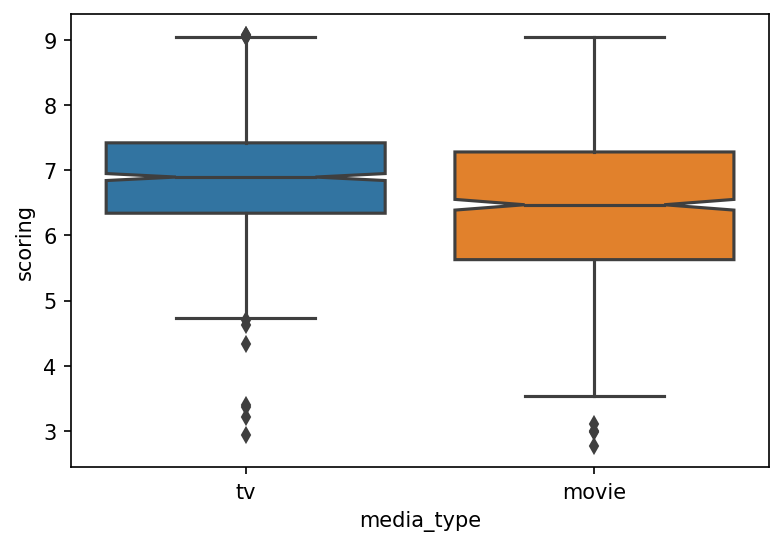

In [23]:
single_sample = create_single_sample(
    population=anime_tv_movie, 
    score_column="scoring", 
    group_column="media_type",
    group_labels=["tv", "movie"], 
    group_sizes=[1000, 1000]
)
ax = sns.boxplot(x="media_type", y="scoring", data=single_sample, notch=True)

In [24]:
single_sample

,media_type,scoring
0,tv,5.63
1,tv,6.14
2,tv,6.59
3,tv,7.89
4,tv,7.00
...,...,...
1995,movie,6.88
1996,movie,7.21
1997,movie,6.78
1998,movie,5.33


In [25]:
sample_statistic = np.mean(single_sample.loc[single_sample.media_type == "tv", "scoring"]) \
    - np.mean(single_sample.loc[single_sample.media_type == "movie", "scoring"])
sample_statistic

0.4517899999999999

So what do we do if we only have this one sample. This is all the data it was practical to gather, and we want to use this to **infer** the 

## Bootstrapping

In [26]:
def create_diff_means_bootstrap_dist(sample, score_column, group_column, group_labels, num_resamples):
    first_sample_group = sample.loc[
        sample[group_column] == group_labels[0], score_column
    ]
    first_sample_group_size = first_sample_group.shape[0]
    second_sample_group = sample.loc[
        sample[group_column] == group_labels[1], score_column
    ]
    second_sample_group_size = second_sample_group.shape[0]
    
    bootstrap_dist_diffs = []
    for i in range(num_resamples):
        first_group_sample = first_sample_group.sample(first_sample_group_size, replace=True)
        second_group_sample = second_sample_group.sample(second_sample_group_size, replace=False)
        
        first_group_sample_mean = first_group_sample.mean()
        second_group_sample_mean = second_group_sample.mean()
        
        this_diff = first_group_sample_mean - second_group_sample_mean
        
        bootstrap_dist_diffs.append([i + 1, \
            first_group_sample_mean, second_group_sample_mean, this_diff])
    
    return pd.DataFrame(
        data=bootstrap_dist_diffs, 
        columns=["resample", f"{group_labels[0]}_mean_{score_column}", \
            f"{group_labels[1]}_mean_{score_column}", "diff_means"]
    )

In [27]:
bootstrap_dist = create_diff_means_bootstrap_dist(
    sample=single_sample,
    score_column="scoring",
    group_column="media_type",
    group_labels=["tv", "movie"],
    num_resamples=50000
)

In [28]:
bootstrap_dist

,resample,tv_mean_scoring,movie_mean_scoring,diff_means
0,1,6.87922,6.44497,0.43425
1,2,6.90188,6.44497,0.45691
2,3,6.97890,6.44497,0.53393
3,4,6.91808,6.44497,0.47311
4,5,6.94373,6.44497,0.49876
...,...,...,...,...
49995,49996,6.93480,6.44497,0.48983
49996,49997,6.95357,6.44497,0.50860
49997,49998,6.96868,6.44497,0.52371
49998,49999,6.88768,6.44497,0.44271


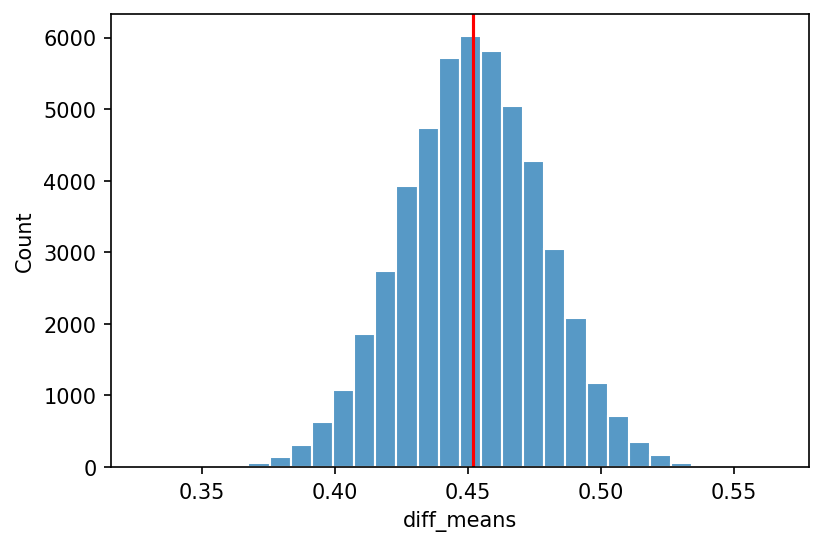

In [29]:
ax = sns.histplot(bootstrap_dist.diff_means, bins=30, edgecolor="white");
plt.axvline(sample_statistic, 0, 1, color="red");

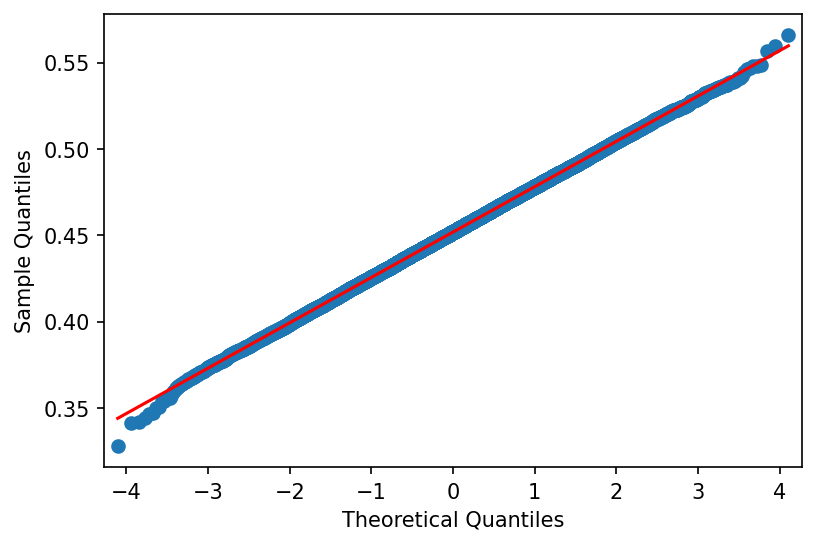

In [46]:
sm.qqplot(bootstrap_dist.diff_means, line="s");

### Percentile bootstrap

In [156]:
def percentile_CI(bootstrap_dist, value_column, confidence_level):
    lower_prob = (1 - confidence_level)/2
    upper_prob = confidence_level + lower_prob
    return np.quantile(bootstrap_dist[value_column], [lower_prob, upper_prob])

In [52]:
percentile_CI(bootstrap_dist, "diff_means", 0.95)

array([0.40009   , 0.50324025])

### Bias-corrected bootstrap

In [157]:
def bias_corrected_CI(bootstrap_dist, sample_stat, value_column, confidence_level):
    '''
    Assumes that bootstrap sampling distribution is normal and should by symmetrically distributed around the 
    sample statistic. Any deviation from latter reflects effects of bias in bootstrap distribution. CI can be 
    corrected to symmetrise distribution around sample statistic. 
    '''
    lower_prob = (1 - confidence_level)/2
    upper_prob = confidence_level + lower_prob
    
    lower_z = norm.ppf(lower_prob)
    upper_z = norm.ppf(upper_prob)
    
    num_below_stat = np.sum(np.array([1 for value in bootstrap_dist[value_column] if value <= sample_stat]))
    frac_below_stat = num_below_stat / bootstrap_dist.shape[0]
    z0 = norm.ppf(frac_below_stat)
    
    corrected_lower_prob = norm.cdf(2 * z0 + lower_z)
    corrected_upper_prob = norm.cdf(2 * z0 + upper_z)
        
    return np.quantile(bootstrap_dist[value_column], [corrected_lower_prob, corrected_upper_prob])

In [67]:
bias_corrected_CI(bootstrap_dist, sample_statistic, "diff_means", 0.95)

array([0.40010708, 0.50324904])

### Improving bootstrap accuracy

We don't really have time to get into them here, but more accurate bootstrap methods exist than the simple percentile and bias-corrected (BC) algorithms presented above. In particular, the double (or studentized) bootstrap offers significant improvements at the cost of increased computational complexity. 

In the latter method, we perform **nested bootstraps**: for each outer bootstrap resample we perform an inner bootstrap, typically with a much smaller number of replications of order 10s-100s. The aim of the inner bootstrap is to estimate the standard error for that particular resample. 

It's easy to appreciate that this inner loop greatly increases the computational burden, naively by a factor of the number of inner replicates, but algorithms based on early stopping rules exist that aim to curb the effort required (see Nankervis 2005 https://doi.org/10.1016/j.csda.2004.05.023).  

![Variation in coverage and CI width of different bootstrap methods with sample size](img/CI_coverage_width_methods.png)
**Fig. 1**: Variation in coverage and CI width of different bootstrap methods with sample size (Bittmann 2021)

**'Coverage'**: we aim to calculate CIs at a particular confidence level, but the effect of small sample sizes and/or skew and outliers can shift confidence away from the anticipated value. The actual value achieved is termed the 'coverage'. We can estimate coverage in the following way:

1. For a given population distribution, calculate the parameter of interest.
2. Pull a random sample from the population (without replacement) of the correct size $n$.
3. Given that sample, calculate a CI for your statistic at the desired confidence level, using your algorithm of choice, making sure the algorithm is converged wrt other variables we control (number of replicates being the main one).
4. Note whether the population parameter lies within the CI.
5. Go to 2 and repeat a decent number of times, e.g. a few thousand.
6. The proportion of calculated CIs containing the population parameter is the coverage achieved for that population distribution, at that sample size, for that bootstrap algorithm.

# Hypothesis testing

## Reminder 

Typically have two **mutually exclusive** (can't both be true simultaneously) and **exhaustive** (no other options) hypotheses we are trying to decide between based on available data. Acknowledging we have choice in how we set up our hypotheses, by convention: 

* We consider the **null** hypothesis $H_0$ to be true by default. This represents the 'conservative' position (business as usual, nothing interesting is happening). In a court case, this would be the 'not guilty' verdict.
* We place the burden of proof on the **alternative** hypothesis $H_a$, which represents the 'active' position (something interesting is happening, new finding, significant change from prior behaviour). In a court case, this would be the 'guilty' verdict, which has to be actively proven (as 'not guilty' is the default judgement).

**Example - Website A/B testing** 

For randomly sampled group of users B (perhaps stratified) show them button in proposed new position, while for remainder group A show them button in old position. Gather click-through rate for both groups. Try to aim for equal group sizes. 
* $H_0 = \textrm{click-through rate in group B is less than or equal to rate in group A}$ 
* $H_a = \textrm{click-through rate in group B is greater than rate in group A}$
* This is an example of a 'one-tailed' test: we are interested in deviations from the null in only one direction ('...greater than...')
* If we had more than two potential button positions we could use an ANOVA style approach where we split incoming users into more than two groups. Our first hypothesis test would be determine whether 'somewhere there exists a significant difference between click-through rates amidst all the groups'. We could then conduct post-hoc tests to determine where any significant differences arise.

The outcome of the test is typically determined by calculating a $p$-value ($p$ standing for probability). This is often misinterpreted: it is **not** the probability that  

# Regression

In [131]:
anime_tv = anime.loc[anime.media_type == "tv", :].dropna(subset=["scoring", "average_episode_duration"])
anime_tv.average_episode_duration

0        0 days 00:24:20
1        0 days 00:23:37
2        0 days 00:24:20
3        0 days 00:24:00
4        0 days 00:23:00
              ...       
23554    0 days 00:07:00
23650    0 days 00:25:00
23740    0 days 00:25:00
23790    0 days 00:24:00
23976    0 days 00:24:20
Name: average_episode_duration, Length: 4175, dtype: object

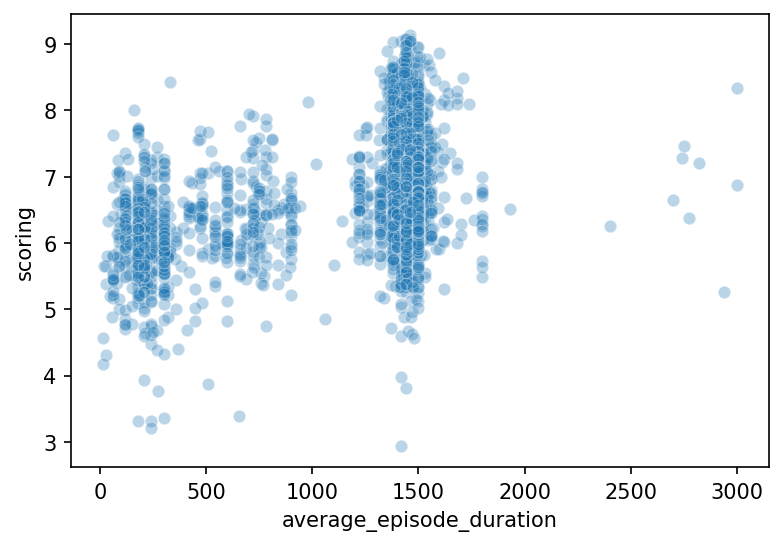

In [132]:
anime_tv.average_episode_duration = pd.to_timedelta(anime.average_episode_duration).apply(lambda x: x.total_seconds())
plot = sns.scatterplot(data=anime_tv, x="average_episode_duration", y="scoring", alpha=0.3);

In [161]:
model = sm.OLS(endog=anime_tv.scoring, exog=sm.add_constant(anime_tv.average_episode_duration)).fit()

In [162]:
model.params

const                       5.883561
average_episode_duration    0.000769
dtype: float64

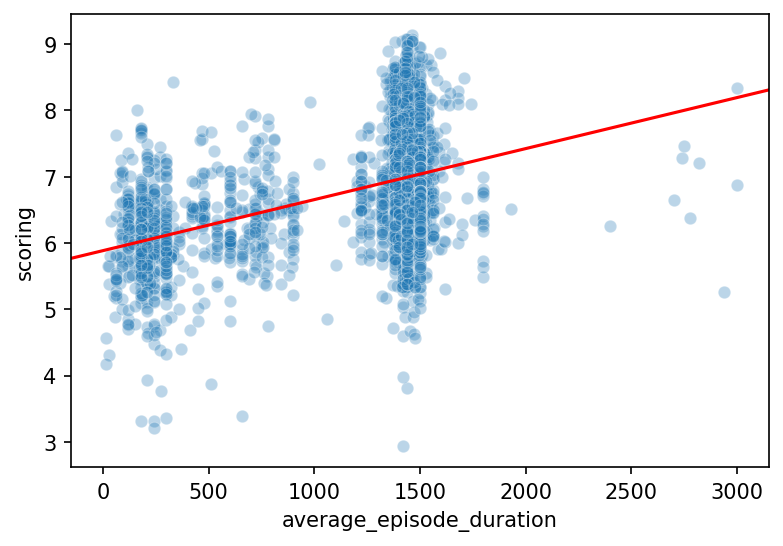

In [124]:
plot = sns.scatterplot(data=anime_tv, x="average_episode_duration", y="scoring", alpha=0.3);
plt.axline(xy1=(0, model.params['const']), slope=model.params['average_episode_duration'], color="red");

In [139]:
model.conf_int(alpha=0.05)

,0,1
const,5.811289,5.955834
average_episode_duration,0.000716,0.000823


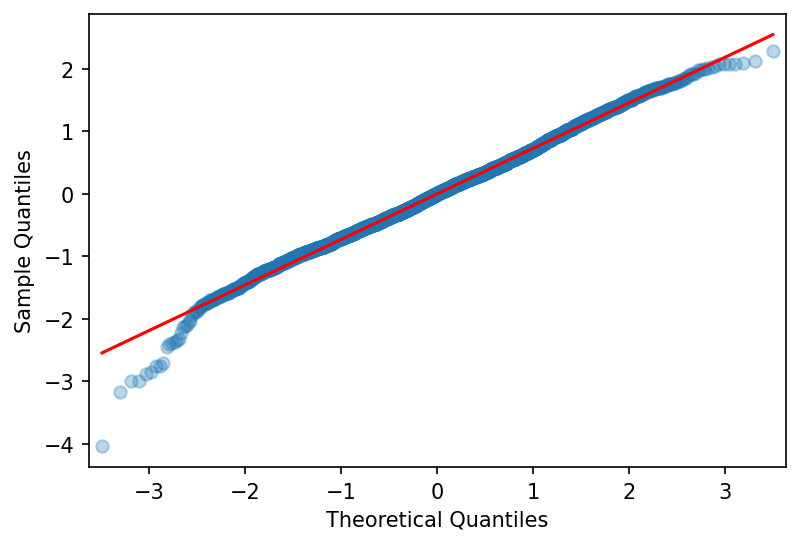

In [130]:
sm.qqplot(model.resid, line="s", alpha=0.3);

In [160]:
def bootstrap_simple_linear_regression(sample, x_column, y_column, num_resamples):
    results = []
    for i in range(num_resamples):
        this_resample = sample.sample(sample.shape[0], replace=True)
        this_model = sm.OLS(endog=this_resample[y_column], exog=sm.add_constant(this_resample[x_column])).fit()
        results.append([i + 1, this_model.params["const"], this_model.params[x_column], this_model.rsquared])
    
    return pd.DataFrame(
        data=results, 
        columns=["resample", "const", x_column, "rsquared"]
    )

In [148]:
bootstrap_regression = bootstrap_simple_linear_regression(anime_tv, "average_episode_duration", "scoring", 10000)

In [164]:
percentile_CI(
    bootstrap_dist=bootstrap_regression,
    value_column="average_episode_duration",
    confidence_level=0.95,
)

array([0.00071362, 0.00082567])

In [163]:
bias_corrected_CI(
    bootstrap_dist=bootstrap_regression,
    value_column="average_episode_duration",
    confidence_level=0.95,
    sample_stat=model.params["average_episode_duration"]
)

array([0.00071395, 0.0008262 ])

In [154]:
percentile_CI

<function __main__.percentile_CI(bootstrap_dist, value_column, confidence_level)>